In [ ]:
#Install Libraries
!pip install  imblearn
!pip install transformers
!pip install datasets
!pip install tensorflow
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
#Import Libraries
import torch
import numpy as np
import pandas as pd
import spacy
import re
import nltk
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datasets import Dataset
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, auc, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.svm import SVC, LinearSVC
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification,Trainer, TrainingArguments
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
import seaborn as sns
import optuna


In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-12-56a81db884b4>:6: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')


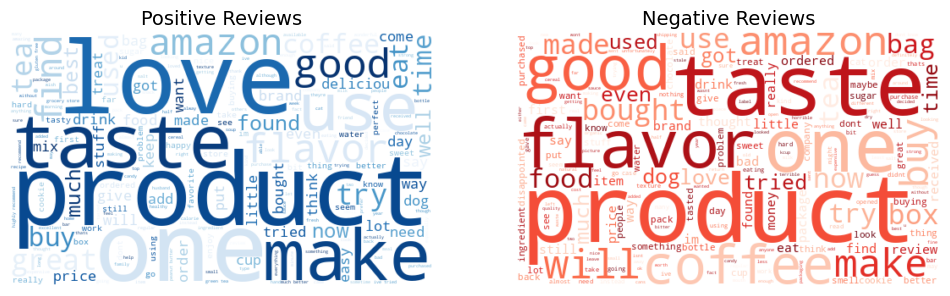

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Load the processed dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')

# Ensure the 'label' column exists
if "label" not in df.columns:
    raise ValueError("The dataset must contain a 'label' column.")

# Ensure the 'processed_review' column exists
if "processed_review" not in df.columns:
    raise ValueError("The dataset must contain a 'processed_review' column.")

# Fill NaN values with an empty string and ensure all values are strings
df["processed_review"] = df["processed_review"].fillna("").astype(str)

# Separate positive and negative reviews
positive_reviews = " ".join(df[df["label"] == "positive"]["processed_review"])
negative_reviews = " ".join(df[df["label"] == "negative"]["processed_review"])

# Generate word clouds
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

wordcloud_pos = WordCloud(width=500, height=300, background_color="white", colormap="Blues").generate(positive_reviews)
ax[0].imshow(wordcloud_pos, interpolation="bilinear")
ax[0].set_title("Positive Reviews", fontsize=14)
ax[0].axis("off")

wordcloud_neg = WordCloud(width=500, height=300, background_color="white", colormap="Reds").generate(negative_reviews)
ax[1].imshow(wordcloud_neg, interpolation="bilinear")
ax[1].set_title("Negative Reviews", fontsize=14)
ax[1].axis("off")

plt.show()


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/Reviews.csv')

# Total number of reviews
total_reviews = df.shape[0]
print(f"Total number of reviews: {total_reviews}")

# Calculate the number of reviews for training and testing
train_size = int(0.8 * total_reviews)  # 80% for training
test_size = total_reviews - train_size  # 20% for testing
print(f"Number of reviews for training: {train_size}")
print(f"Number of reviews for testing: {test_size}")

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)



Total number of reviews: 568454
Number of reviews for training: 454763
Number of reviews for testing: 113691


In [ ]:
import pandas as pd

# Load Fine Food Reviews dataset
fine_food_df = pd.read_csv("/content/drive/MyDrive/FineFoodDataset/Reviews.csv")
fine_food_df['review_length'] = fine_food_df['Text'].apply(lambda x: len(str(x).split()))

# Calculate statistics for Fine Food Reviews
fine_food_summary = pd.DataFrame({
    "Metric": ["Total Reviews", "Unique Products", "Avg. Review Length (words)", "Std. Dev of Length", "Sentiment Distribution (Positive %)"],
    "Fine Food Reviews": [
        len(fine_food_df),
        fine_food_df['ProductId'].nunique(),
        fine_food_df['review_length'].mean(),
        fine_food_df['review_length'].std(),
        (fine_food_df['Score'] >= 4).mean() * 100
    ]
})

# Display Fine Food dataset statistics
display(fine_food_summary)

,Metric,Fine Food Reviews
0,Total Reviews,568454.000000
1,Unique Products,74258.000000
2,Avg. Review Length (words),80.264023
3,Std. Dev of Length,79.455384
4,Sentiment Distribution (Positive %),78.067355


**1-Data Cleaning:** Clean the dataset by removing duplicates, irrelevant content, handling missing values and Lowercasing.

In [ ]:
# Load the dataset(500,000 food reviews:568,454 reviews,256,059 users and 74,258 products)
file_path = "/content/drive/MyDrive/FineFoodDataset/Reviews.csv"
df = pd.read_csv(file_path)

# Remove duplicates based on two columns ('UserId' and 'Text')
df = df.drop_duplicates(subset=['UserId','Text'])
print("\nDuplicates removed. Number of rows after removing duplicates:")
print(df.shape[0])

# Handle missing values by drop rows with missing 'Text' or 'Score'
df = df.dropna(subset=['Text', 'Score'])
print("\nRows with missing 'Text' or 'Score' removed. Number of rows after removal:")
print(df.shape[0])

# Remove HTML tags directly in the 'Text' column
df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) and '<' in x and '>' in x else x)

# Remove promotional content
df['Text'] = df['Text'].apply(lambda x:re.sub(r'get \d+% off|use code|promo code', '', x))

# Remove URLs in the same column
df['Text'] = df['Text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))

 # Remove extra whitespace
df['Text'] = df['Text'].apply(lambda x:re.sub(r'\s+', ' ', x).strip())

# Lowercase the review text
df['Text'] = df['Text'].astype(str).str.lower()

# Save the cleaned dataset to a new CSV file
df.to_csv("/content/drive/MyDrive/FineFoodDataset/CleanedReviews.csv", index=False)
print("\nCleaned dataset saved successfully.")


Duplicates removed. Number of rows after removing duplicates:
393606

Rows with missing 'Text' or 'Score' removed. Number of rows after removal:
393606

Cleaned dataset saved successfully.


**2- Preprocess Data:**Tokenization, Removing stop words, Stemming/Lemmatization and
Removing special character

In [ ]:
import nltk
import spacy
import re
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from datasets import Dataset

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = nlp.Defaults.stop_words

# Load sentiment analyzer (VADER for automatic negation detection)
sia = SentimentIntensityAnalyzer()

# Load sarcasm detection model (Using DeBERTa as a better alternative)
sarcasm_model = pipeline("text-classification", model="microsoft/deberta-v3-base")

# Function to handle negation using VADER
def handle_negation_vader(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score["neg"] > 0.5:  # If strong negative sentiment detected
        return "NOT_" + text  # Attach NOT_ prefix for emphasis
    return text

# Function to detect sarcasm
def detect_sarcasm(text):
    result = sarcasm_model(text)
    label = result[0]['label']

    if label.lower() == "sarcasm":
        return "SARCASM: " + text  # Tag sarcastic sentences
    return text

# Preprocessing function
def preprocess_review(text, use_lemmatization=True):
    if not isinstance(text, str):
        return ''

    # Remove special characters except punctuation
    text = re.sub(r'[^a-zA-Z\s.!?]', '', text)

    # Tokenization using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stop words using SpaCy stopwords
    tokens = [word for word in tokens if word not in spacy_stopwords]

    # Lemmatization (if enabled)
    if use_lemmatization:
        tokens = [token.lemma_ for token in doc]

    # Apply automatic negation handling
    text = handle_negation_vader(text)

    # Detect sarcasm
    text = detect_sarcasm(text)

    return text

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/CleanedReviews.csv')

# Handle NaN values in 'Reviews' column
df['review'] = df['Text'].fillna('')

# Apply preprocessing using datasets library
dataset = Dataset.from_pandas(df)
dataset = dataset.map(lambda x: {'processed_review': preprocess_review(x['review'])})

# Convert back to pandas dataframe and save processed data
df_processed = dataset.to_pandas()

# Save processed data to CSV, keeping all columns
df_processed.to_csv('/content/drive/MyDrive/FineFoodDataset/PreprocessedReviews.csv', index=False)

print("✅ Preprocessing completed with automatic negation and sarcasm handling!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


Map:   0%|          | 0/393606 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Preprocessing completed with automatic negation and sarcasm handling!


In [ ]:
#add label/sentiment column
df = pd.read_csv("/content/drive/MyDrive/FineFoodDataset/PreprocessedReviews.csv")

# Step 2: Create the 'label' column based on an existing 'Score' column or using a model
# Example: Based on score column mapping
def map_score_to_label(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply function to create the label column
df['label'] = df['Score'].apply(map_score_to_label)

# Step 3: Save the updated DataFrame back to a new CSV file
df.to_csv("/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv", index=False)  # Save without row indices


<ipython-input-7-097eadfbea5b>:2: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/FineFoodDataset/PreprocessedReviews.csv")


<ipython-input-8-066d09c20962>:2: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv")


label
positive    306774
negative     57076
neutral      29756
Name: count, dtype: int64


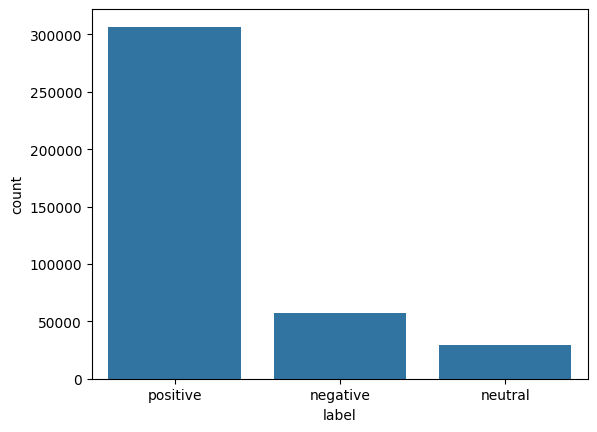

In [ ]:
# ensure the dataset is correctly labeled for sentiment (positive, negative, neutral)
df = pd.read_csv("/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv")

# Assuming your labels are in the 'label' column
label_counts = df['label'].value_counts()
print(label_counts)

# Visualize distribution
sns.countplot(data=df, x='label')
plt.show()

**3- Feature Extraction and Machine Learning Models:** **Feature Extraction** to Convert text data into numerical data using TF-IDF.
**ML models:**Logistic Regression
,Naive Bayes, Support Vector Machines (SVM), Random Forest and Gradient Boosting Machines (GBM)

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path

# Retain only the required columns for processing (Assuming 'Score' is the label)
df = df[['processed_review', 'label']]

# Remove rows with NaN values in the 'review' column
df = df.dropna(subset=['processed_review'])

# Balance the dataset using undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df[['processed_review']], df['label'])

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'processed_review': X_resampled['processed_review'], 'label': y_resampled})

# Define X and y
X = balanced_df['processed_review']
y = balanced_df['label']

# Encode labels for multiclass classification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Evaluation function
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

def evaluate_model(y_true, y_pred, y_proba=None, average='binary'):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr') if y_proba is not None else 'N/A'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}\n")
     # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

<ipython-input-4-8986359b75da>:2: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path



Random Forest:
Accuracy: 0.6177
Precision: 0.6221
Recall: 0.6183
F1 Score: 0.6134
ROC AUC: 0.8060045334127873



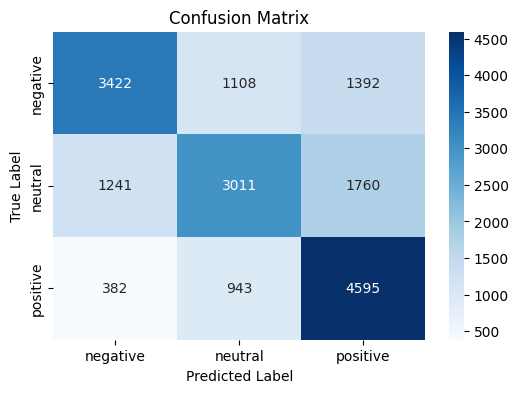

In [ ]:
# Train and evaluate Random Forest
print("\nRandom Forest:")
rf = RandomForestClassifier(max_depth=10,min_samples_split=5,min_samples_leaf=2)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
y_proba_rf = rf.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else rf.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_rf, y_proba_rf if len(le.classes_) == 2 else y_proba_rf, average='macro' if len(le.classes_) > 2 else 'binary')


Logistic Regression:
Accuracy: 0.7414
Precision: 0.7416
Recall: 0.7418
F1 Score: 0.7417
ROC AUC: 0.8948510860104061



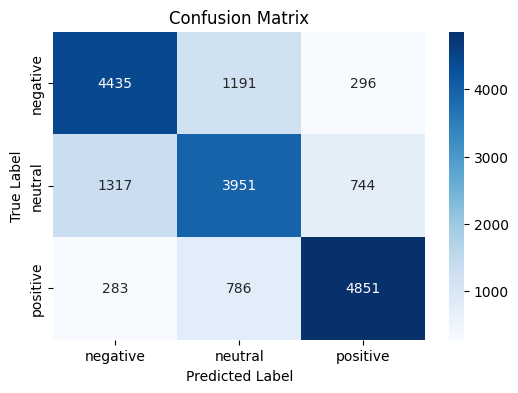


Naive Bayes:
Accuracy: 0.7222
Precision: 0.7270
Recall: 0.7225
F1 Score: 0.7243
ROC AUC: 0.8769334246699035



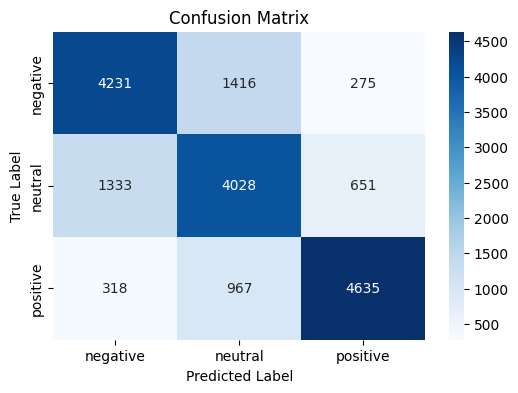

In [ ]:
#Machine Learning
# Train and evaluate Logistic Regression
print("\nLogistic Regression:")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)
y_proba_lr = log_reg.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else log_reg.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_lr, y_proba_lr if len(le.classes_) == 2 else y_proba_lr, average='macro' if len(le.classes_) > 2 else 'binary')

# Train and evaluate Naive Bayes
print("\nNaive Bayes:")
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_proba_nb = nb.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else nb.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_nb, y_proba_nb if len(le.classes_) == 2 else y_proba_nb, average='macro' if len(le.classes_) > 2 else 'binary')


Gradient Boosting Machine:
Accuracy: 0.6559
Precision: 0.6578
Recall: 0.6561
F1 Score: 0.6567
ROC AUC: 0.8293631458913264



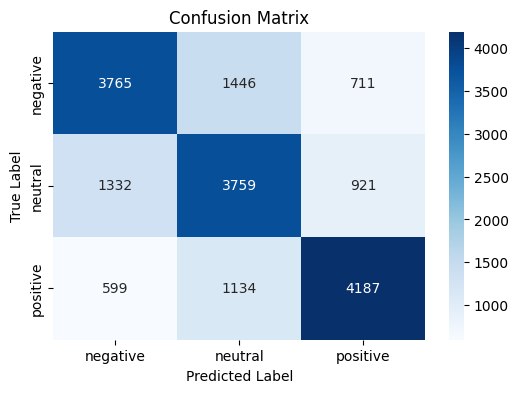

In [ ]:
# Train and evaluate Gradient Boosting Machines (GBM)
print("\nGradient Boosting Machine:")
gbm = GradientBoostingClassifier(min_samples_split=5,min_samples_leaf=2)
gbm.fit(X_train_tfidf, y_train)
y_pred_gbm = gbm.predict(X_test_tfidf)
y_proba_gbm = gbm.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else gbm.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_gbm, y_proba_gbm if len(le.classes_) == 2 else y_proba_gbm, average='macro' if len(le.classes_) > 2 else 'binary')


Support Vector Machine:
Accuracy: 0.7341
Precision: 0.7329
Recall: 0.7347
F1 Score: 0.7335
ROC AUC: 0.8875370291713945



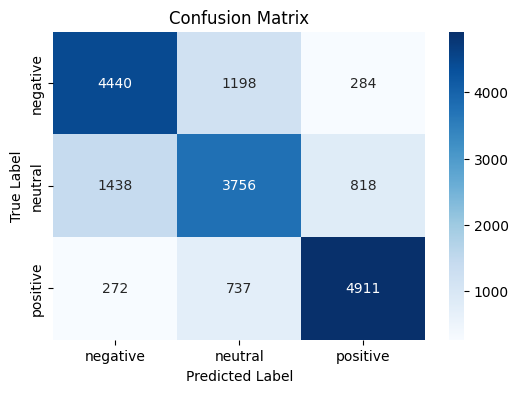

In [ ]:
# Train and evaluate Support Vector Machines (SVM)
print("\nSupport Vector Machine:")
svc = LinearSVC()
svm = CalibratedClassifierCV(svc, cv=5)
# Train the calibrated model
svm.fit(X_train_tfidf, y_train)
# Get probability predictions on the test set
svm_pred_proba = svm.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else svm.predict_proba(X_test_tfidf)
y_pred = svm.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, svm_pred_proba if len(le.classes_) == 2 else svm_pred_proba, average='macro' if len(le.classes_) > 2 else 'binary')

**5- Deep Learning :**Train and evaluate deep learning models:Long Short Term Memory(LSTM),Convolutional Neural Networks (CNNs) and Roberta


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path
X = df['processed_review']
y = df['label']

# Balance the dataset using undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df[['processed_review']], df['label'])

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'processed_review': X_resampled['processed_review'], 'label': y_resampled})

# Define X and y
X = balanced_df['processed_review']
y = balanced_df['label']

# Encode labels
lb = LabelBinarizer()
y = lb.fit_transform(y)
if y.shape[1] == 1:  # For binary labels
    y = y.ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check for NaN values and replace with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Ensure all values are strings
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Tokenize for deep learning models
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define CNN model
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),  # Adjust input_dim and input_length as needed
        Conv1D(64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
         Dropout(0.2),
        Dense(3, activation='softmax')  # Match number of output units to your classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define LSTM model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(3, activation='softmax')  # Match number of output units to your classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define evaluation function
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Get predicted probabilities
    y_pred_proba = model.predict(X_test)

    # Convert probabilities to class labels
    if y_pred_proba.shape[1] == 1:
        # Binary classification case
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Threshold at 0.5 for binary class
    else:
        # Multi-class classification case
        y_pred = np.argmax(y_pred_proba, axis=1)  # For multi-class, take argmax

    # Convert y_test to integers if it's one-hot encoded
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate ROC AUC score based on binary or multi-class
    if y_pred_proba.shape[1] == 1:
        # Binary ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        # Multi-class ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print results
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1 Score: {f1:.4f}")
    print(f"{model_name} - ROC AUC: {roc_auc:.4f}")
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


<ipython-input-4-17f0cca6bf55>:2: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path



Training CNN Model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2232/2232 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.5964 - loss: 0.8485 - val_accuracy: 0.7210 - val_loss: 0.6457
Epoch 2/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.7495 - loss: 0.5949 - val_accuracy: 0.7227 - val_loss: 0.6403
Epoch 3/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.8008 - loss: 0.4934 - val_accuracy: 0.7229 - val_loss: 0.6518
Epoch 4/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8385 - loss: 0.4136 - val_accuracy: 0.7140 - val_loss: 0.6991
Epoch 5/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8686 - loss: 0.3415 - val_accuracy: 0.7082 - val_loss: 0.7530
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CNN - Accuracy: 0.7082
CNN - Precision: 0.7120
CNN - Recall: 0.7086
CNN - F1 Score: 0.7100
CNN - ROC AUC: 0.8686


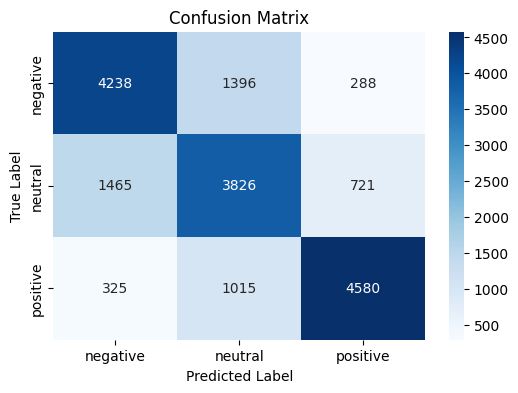

In [ ]:
# Train and evaluate the CNN model
print("\nTraining CNN Model...")
cnn_model = build_cnn_model()
cnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)
evaluate_model(cnn_model, X_test_padded, y_test, model_name="CNN")

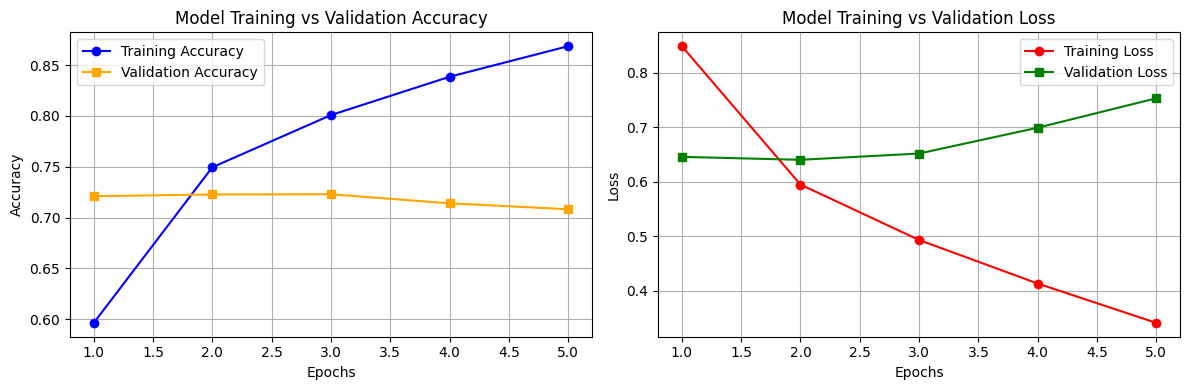

In [ ]:
import matplotlib.pyplot as plt

# Updated data for the model
epochs = [1, 2, 3, 4, 5]
train_accuracy = [0.5964, 0.7495, 0.8008, 0.8385, 0.8686]
val_accuracy = [0.7210, 0.7227, 0.7229, 0.7140, 0.7082]
train_loss = [0.8485, 0.5949, 0.4934, 0.4136, 0.3415]
val_loss = [0.6457, 0.6403, 0.6518, 0.6991, 0.7530]

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
axs[0].plot(epochs, train_accuracy, marker="o", linestyle="-", color="blue", label="Training Accuracy")
axs[0].plot(epochs, val_accuracy, marker="s", linestyle="-", color="orange", label="Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Model Training vs Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(epochs, train_loss, marker="o", linestyle="-", color="red", label="Training Loss")
axs[1].plot(epochs, val_loss, marker="s", linestyle="-", color="green", label="Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Model Training vs Validation Loss")
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


Training LSTM Model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2232/2232 ━━━━━━━━━━━━━━━━━━━━ 347s 154ms/step - accuracy: 0.3439 - loss: 1.0987 - val_accuracy: 0.3478 - val_loss: 1.0979
Epoch 2/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 344s 154ms/step - accuracy: 0.3486 - loss: 1.0926 - val_accuracy: 0.3406 - val_loss: 1.0980
Epoch 3/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 339s 152ms/step - accuracy: 0.3567 - loss: 1.0815 - val_accuracy: 0.3391 - val_loss: 1.1068
Epoch 4/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 343s 154ms/step - accuracy: 0.3675 - loss: 1.0562 - val_accuracy: 0.5516 - val_loss: 0.9462
Epoch 5/5
2232/2232 ━━━━━━━━━━━━━━━━━━━━ 341s 153ms/step - accuracy: 0.6403 - loss: 0.7832 - val_accuracy: 0.7099 - val_loss: 0.6912
558/558 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step
LSTM - Accuracy: 0.7099
LSTM - Precision: 0.7079
LSTM - Recall: 0.7105
LSTM - F1 Score: 0.7089
LSTM - ROC AUC: 0.8670


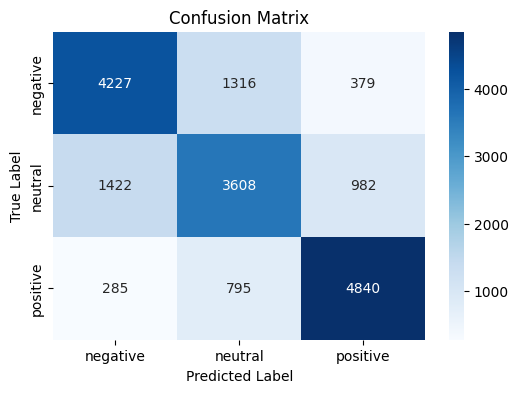

In [ ]:
# Train and evaluate the LSTM model
print("\nTraining LSTM Model...")
lstm_model = build_lstm_model()
lstm_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)
evaluate_model(lstm_model, X_test_padded, y_test, model_name="LSTM")

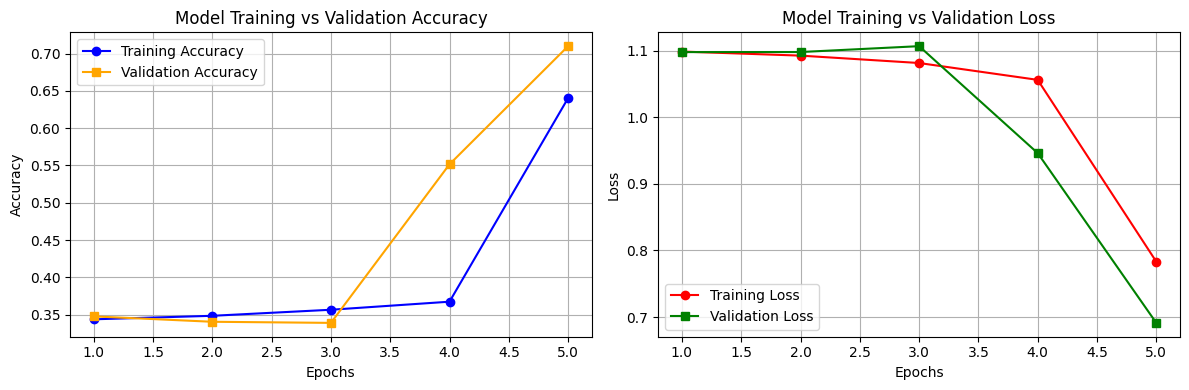

In [ ]:
import matplotlib.pyplot as plt

# Data for the new model based on updated results
epochs = [1, 2, 3, 4, 5]
train_accuracy = [0.3439, 0.3486, 0.3567, 0.3675, 0.6403]
val_accuracy = [0.3478, 0.3406, 0.3391, 0.5516, 0.7099]
train_loss = [1.0987, 1.0926, 1.0815, 1.0562, 0.7832]
val_loss = [1.0979, 1.0980, 1.1068, 0.9462, 0.6912]

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
axs[0].plot(epochs, train_accuracy, marker="o", linestyle="-", color="blue", label="Training Accuracy")
axs[0].plot(epochs, val_accuracy, marker="s", linestyle="-", color="orange", label="Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Model Training vs Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(epochs, train_loss, marker="o", linestyle="-", color="red", label="Training Loss")
axs[1].plot(epochs, val_loss, marker="s", linestyle="-", color="green", label="Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Model Training vs Validation Loss")
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-4-2d7677e8c9da>:14: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-2d7677e8c9da>:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.510900,0.501789,0.790579,0.789506,0.791308,0.788664,N/A
2,0.446400,0.505004,0.796628,0.801968,0.796856,0.798763,N/A
3,0.328200,0.555789,0.795284,0.795249,0.795771,0.795427,N/A


{'accuracy': 0.7905791419289795, 'precision': 0.7895060313035497, 'recall': 0.7913079553216832, 'f1': 0.7886639494520645, 'roc_auc': 'N/A'}
{'accuracy': 0.7966282065643553, 'precision': 0.8019677671525711, 'recall': 0.7968556777752216, 'f1': 0.7987634787405812, 'roc_auc': 'N/A'}
{'accuracy': 0.7952839699787162, 'precision': 0.7952492000277696, 'recall': 0.7957708762126522, 'f1': 0.7954266774040787, 'roc_auc': 'N/A'}


{'accuracy': 0.7905791419289795, 'precision': 0.7895060313035497, 'recall': 0.7913079553216832, 'f1': 0.7886639494520645, 'roc_auc': 'N/A'}
Evaluation Results: {'eval_loss': 0.5017890930175781, 'eval_accuracy': 0.7905791419289795, 'eval_precision': 0.7895060313035497, 'eval_recall': 0.7913079553216832, 'eval_f1': 0.7886639494520645, 'eval_roc_auc': 'N/A', 'eval_runtime': 31.1034, 'eval_samples_per_second': 574.021, 'eval_steps_per_second': 35.88, 'epoch': 3.0}
{'accuracy': 0.7905791419289795, 'precision': 0.7895060313035497, 'recall': 0.7913079553216832, 'f1': 0.7886639494520645, 'roc_auc': 'N/A'}


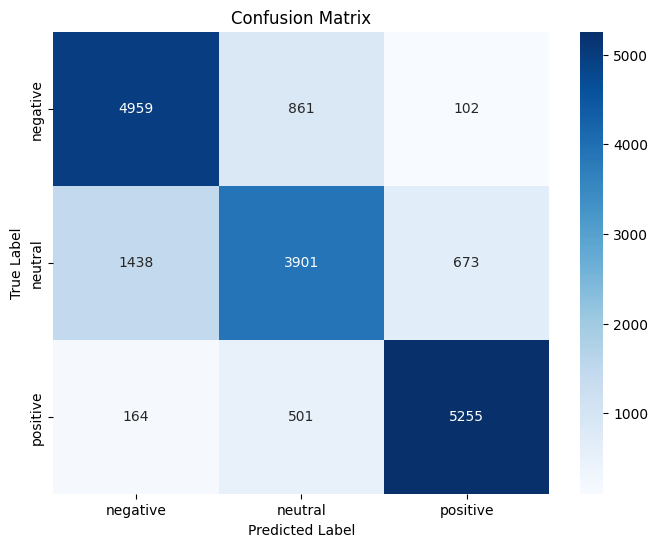

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from imblearn.under_sampling import RandomUnderSampler

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path
df = df[['review', 'label']].dropna()

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split data into text and labels
texts = df['review'].tolist()
labels = np.array(df['label'])  # Convert labels to NumPy array

# Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the entire dataset first
encoded_inputs = tokenizer(
    texts,
    max_length=128,
    truncation=True,
    padding="max_length",
    return_tensors="np",
)
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
input_ids_resampled, labels_resampled = rus.fit_resample(input_ids, labels)
attention_masks_resampled, _ = rus.fit_resample(attention_masks, labels)

# Get indices of resampled data to filter texts
indices_resampled = rus.sample_indices_
texts_resampled = [texts[i] for i in indices_resampled]  # Get the corresponding resampled texts

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'processed_review': texts_resampled, 'label': labels_resampled})

# Train-test split
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids_resampled,
    attention_masks_resampled,
    labels_resampled,
    test_size=0.2,
    random_state=42,
)

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets
train_dataset = SentimentDataset(X_train_ids, X_train_masks, y_train)
val_dataset = SentimentDataset(X_test_ids, X_test_masks, y_test)

# Roberta Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(le.classes_))

# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    pred_proba = pred.predictions  # probabilities for each class

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    # Compute ROC-AUC score for multi-class
    try:
        roc_auc = roc_auc_score(labels, pred_proba, multi_class="ovr", average="macro", labels=np.unique(labels))
    except ValueError:
        roc_auc = "N/A"  # Handle edge cases (e.g., single class in test set)

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc if roc_auc != "N/A" else "N/A",
    }
    print(metrics)
    return metrics

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save the model and tokenizer
model.save_pretrained("./roberta_sentiment")
tokenizer.save_pretrained("./roberta_sentiment")

# Generate Confusion Matrix
predictions = trainer.predict(val_dataset)  # Get predictions
preds = np.argmax(predictions.predictions, axis=-1)  # Get predicted class indices
y_true = predictions.label_ids  # Get true labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


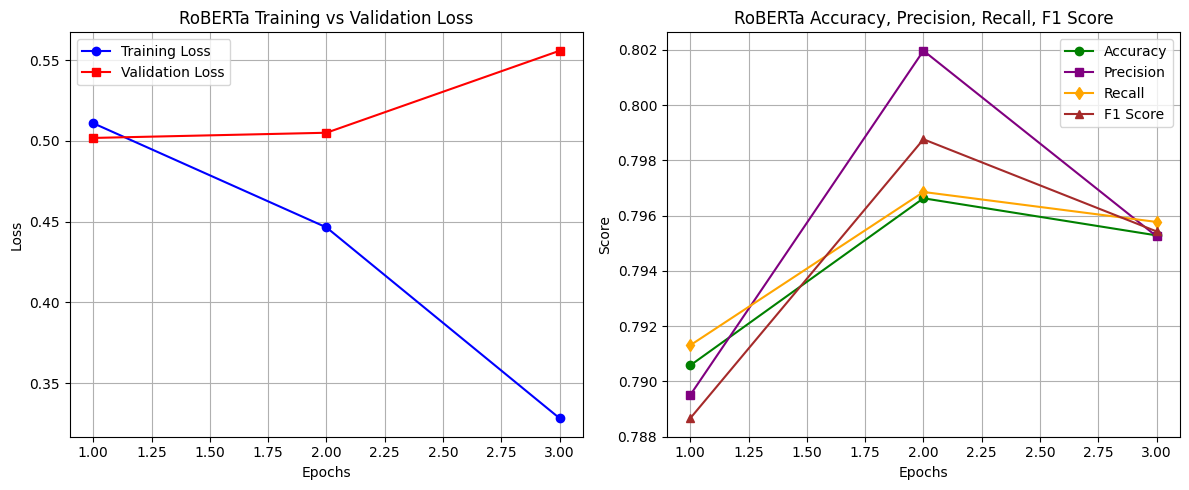

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3]

# Updated Training and Validation Loss values
training_loss = [0.510900, 0.446400, 0.328200]
validation_loss = [0.501789, 0.505004, 0.555789]

# Accuracy, Precision, Recall, F1
accuracy = [0.790579, 0.796628, 0.795284]
precision = [0.789506, 0.801968, 0.795249]
recall = [0.791308, 0.796856, 0.795771]
f1_score = [0.788664, 0.798763, 0.795427]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training vs Validation Loss
axes[0].plot(epochs, training_loss, marker="o", linestyle="-", color="blue", label="Training Loss")
axes[0].plot(epochs, validation_loss, marker="s", linestyle="-", color="red", label="Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("RoBERTa Training vs Validation Loss")
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy, Precision, Recall, F1 Score
axes[1].plot(epochs, accuracy, marker="o", linestyle="-", color="green", label="Accuracy")
axes[1].plot(epochs, precision, marker="s", linestyle="-", color="purple", label="Precision")
axes[1].plot(epochs, recall, marker="d", linestyle="-", color="orange", label="Recall")
axes[1].plot(epochs, f1_score, marker="^", linestyle="-", color="brown", label="F1 Score")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Score")
axes[1].set_title("RoBERTa Accuracy, Precision, Recall, F1 Score")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
